## Pre Processing


In [1]:
import torch
from scipy.misc import imsave
from torchvision.utils import save_image
import torchvision.datasets
from tqdm import tqdm
import torchvision.transforms as transforms
from torch.autograd import grad as torch_grad
from torch.utils.data import dataset
from torch import nn
import matplotlib.pyplot as plt
import scipy.io
from matplotlib.pyplot import imshow
from __future__ import print_function
from PIL import Image
from torch import autograd
from torch.autograd.variable import Variable
import os
import os.path
import numpy as np
import errno
import torchvision.utils as vutils
!pip3 install tensorboardX
from tensorboardX import SummaryWriter
from IPython import display
import random
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import (SubsetRandomSampler,
                                      RandomSampler)
from torchvision import datasets, transforms
import math
%matplotlib inline

# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print('\n Current Device: ', device)



 Current Device:  cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pre Process And Dataloader

In [3]:

image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5),
                         (.5, .5, .5))
])

def get_data_loader(dataset_location, batch_size):
    trainvalid = torchvision.datasets.SVHN(
        dataset_location, split='train',
        download=True,
        transform=image_transform
    )

    trainset_size = int(len(trainvalid) * 0.9)
    trainset, validset = dataset.random_split(
        trainvalid,
        [trainset_size, len(trainvalid) - trainset_size]
    )

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    validloader = torch.utils.data.DataLoader(
        validset,
        batch_size=batch_size,
    )

    testloader = torch.utils.data.DataLoader(
        torchvision.datasets.SVHN(
            dataset_location, split='test',
            download=True,
            transform=image_transform
        ),
        batch_size=batch_size,
    )

    return trainloader, validloader, testloader
# Those are the three data loaders to access data
BATCH_SIZE = 64
train_loader, valid_loader, test_loader = get_data_loader("svhn", BATCH_SIZE)


Using downloaded and verified file: svhn/train_32x32.mat
Using downloaded and verified file: svhn/test_32x32.mat


## Generator

In [0]:

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# Generator Code

class Generator_dc(nn.Module):
    def __init__(self):
        super(Generator_dc, self).__init__()
         
        self.linear = nn.Linear(100, 256)
      
        self.decoder = nn.Sequential(
          nn.ConvTranspose2d(256, 128, kernel_size=4),
          nn.BatchNorm2d(128),
          nn.ELU(),                    
          nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(64),
          nn.ELU(),
          nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(32),
          nn.ELU(),
          nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
          nn.Tanh()
          )
        
        
    def forward(self, z):
        z = self.linear(z)
        z = self.decoder(z.view(z.size(0), 256, 1, 1))
        return z
        
        
    

#generator_dc.apply(weights_init)

In [0]:
def get_noise(size):
  #x = np.random.normal(0, 1, (size, 100))
  x = torch.randn(size, 100).to(device)
  return x

def showImg(img): 
    image = np.squeeze(img.data.cpu().numpy())
    image=image*0.5+0.5
    image = image.transpose((1, 2, 0))
    plt.imshow(image)
    plt.show()


def sample_gen(generator):
  # Create batch of latent vectors that we will use to visualize
  #  the progression of the generator
  fixed_noise = get_noise(1)

  test = generator_dc(fixed_noise)
  #test = test.cpu().detach().numpy()
  #test = Image.fromarray(test[0,:,:,:],'RGB')
  showImg(test)
  
  return test
#sample_gen(discriminator_dc)

## Discriminator

In [0]:

      
class Discriminator_dc(nn.Module):
    def __init__(self):
        super(Discriminator_dc, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            #nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            #nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(3, 32 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 2),
            nn.ReLU(),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(32 * 2, 32 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 4),
            nn.ReLU(),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(32 * 4, 32 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 8),
            nn.ReLU(),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(32 * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input)

In [0]:
#a = generator_dc(get_noise(BATCH_SIZE))
#discriminator_dc(a)[3]

## Trainers

In [0]:
def ones_target(size):
  # For real data
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
  # For fake data
    data = Variable(torch.zeros(size, 1))
    return data

  
def gradient_penalty(x, y, l):
    a=torch.FloatTensor(np.random.uniform(0, 1, (x.size(0), 1))).to(device).expand((x.view(-1,3*32*32)).size())
#   print(x.view(-1,3*3*32).size())
    z=(a*x.view(-1,3*32*32)+(1-a)*y.view(-1,3*32*32)).view(-1,3,32,32)
    z= torch.autograd.Variable(z, requires_grad=True)
    Tz=discriminator_dc(z)
    gradients = torch.autograd.grad(Tz,z,grad_outputs= torch.ones(Tz.size()).to(device),create_graph=True, retain_graph=True, only_inputs=True)
#   print(gradients[0].view(-1,3*32*32).size())
#   print(((gradients[0].view(-1,3*32*32).norm(2, dim=1)-1)**2).mean())
    return ((gradients[0].view(-1,3*32*32).norm(2, dim=1)-1)**2).mean()
      
def loss_WD(x, y, l):
        """
        Implementation of Wasserstein Distance with gradient penalty.
        """
        gp = gradient_penalty(x, y, l)

        return torch.mean(discriminator_dc(x)) - torch.mean(discriminator_dc(y)) - l*gp

      
      
def loss_func(x, y, l=10):
        """
        Implementation of criterion to train the discriminator
        """
        return  loss_WD(x, y, l=10)


In [0]:

one = torch.FloatTensor([1])
mone = one * -1

one = one.to(device)
mone = mone.to(device)



def train_discriminator(N, optimizer, real_data, fake_data, GP_lmbd=10):
    
    # Reset gradients
    optimizer.zero_grad()
    
    discriminator_dc.train()
    generator_dc.train()
    '''
    d_real = discriminator_dc(real_data)
    d_real = d_real.mean()
    d_real.backward(mone)
    
    d_fake = discriminator_dc(fake_data)
    d_fake = d_fake.mean()
    d_fake.backward(one)
    '''
###### WGAN's actual gradient penalty loss:
    wdloss = -loss_WD(real_data, fake_data, l=10)
    
    wdloss.backward()
  
    # Update weights with gradients from gp
    optimizer.step()
    
    
    # Return error and predictions for real and fake inputs
    return wdloss


def train_generator(optimizerg, optimizerd,  fake_data):
    N = fake_data.size(0)
    
    # Reset gradients
    optimizerg.zero_grad()
    optimizerd.zero_grad()
    
    # Sample noise and generate fake data
    fake_data = generator_dc(get_noise(fake_data.shape[0]))
    
    prediction = discriminator_dc(fake_data)
    
    error = -torch.mean(prediction)
    
    error.backward()
    optimizerg.step()
    
    # Return error
    return error

## Main Training

  0%|          | 0/1031 [00:00<?, ?it/s]

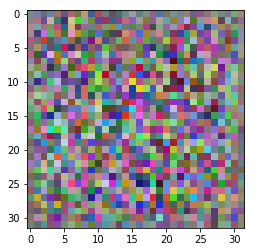

 97%|█████████▋| 999/1031 [01:05<00:02, 15.58it/s]

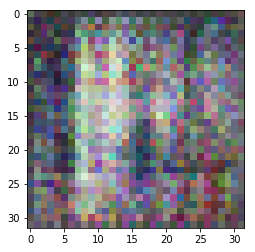

  0%|          | 0/1031 [00:00<?, ?it/s]


 Epoch  0  done.
Discriminator sum WD-GP Loss:  -121.10869598388672
Generator train Loss:  tensor(165150.7812, device='cuda:0', grad_fn=<AddBackward0>)
Batch time:  68.18754935264587 
 



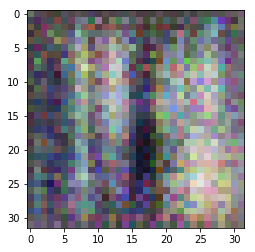

 97%|█████████▋| 999/1031 [01:05<00:02, 15.48it/s]

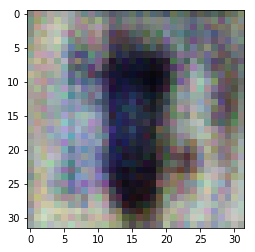

  0%|          | 0/1031 [00:00<?, ?it/s]


 Epoch  1  done.
Discriminator sum WD-GP Loss:  -0.008115208707749844
Generator train Loss:  tensor(234653.0469, device='cuda:0', grad_fn=<AddBackward0>)
Batch time:  67.55223393440247 
 



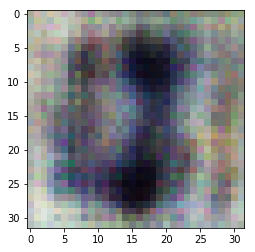

 97%|█████████▋| 999/1031 [01:05<00:02, 15.24it/s]

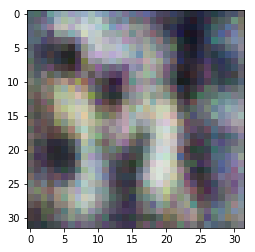

  0%|          | 0/1031 [00:00<?, ?it/s]


 Epoch  2  done.
Discriminator sum WD-GP Loss:  -0.10080511122941971
Generator train Loss:  tensor(233894.9375, device='cuda:0', grad_fn=<AddBackward0>)
Batch time:  67.68254590034485 
 



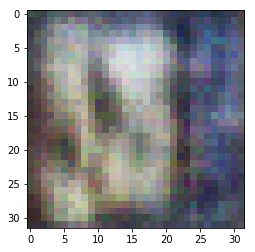

 97%|█████████▋| 999/1031 [01:05<00:02, 15.03it/s]

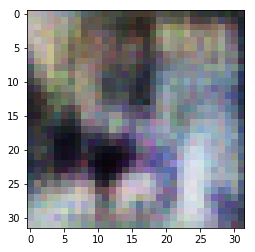

  0%|          | 0/1031 [00:00<?, ?it/s]


 Epoch  3  done.
Discriminator sum WD-GP Loss:  -0.45298320055007935
Generator train Loss:  tensor(232762.0938, device='cuda:0', grad_fn=<AddBackward0>)
Batch time:  67.68533611297607 
 



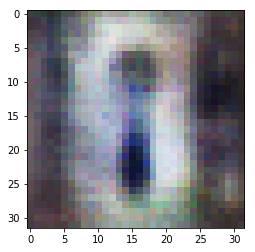

 97%|█████████▋| 999/1031 [01:05<00:02, 15.25it/s]

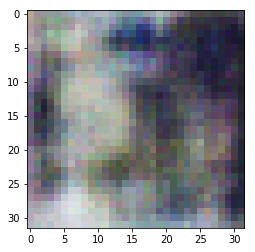

  0%|          | 0/1031 [00:00<?, ?it/s]


 Epoch  4  done.
Discriminator sum WD-GP Loss:  -1.1953816413879395
Generator train Loss:  tensor(227139.1562, device='cuda:0', grad_fn=<AddBackward0>)
Batch time:  67.74787735939026 
 



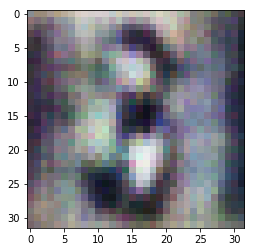

 97%|█████████▋| 999/1031 [01:05<00:02, 15.09it/s]

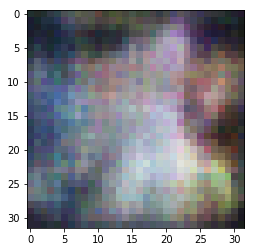

  0%|          | 0/1031 [00:00<?, ?it/s]


 Epoch  5  done.
Discriminator sum WD-GP Loss:  -1.6991698741912842
Generator train Loss:  tensor(213412.3281, device='cuda:0', grad_fn=<AddBackward0>)
Batch time:  67.71442246437073 
 



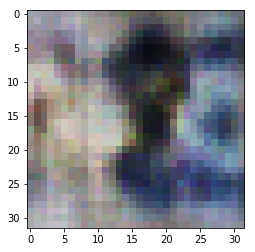

 97%|█████████▋| 999/1031 [01:05<00:02, 15.34it/s]

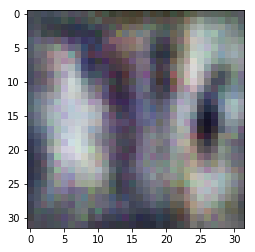

  0%|          | 0/1031 [00:00<?, ?it/s]


 Epoch  6  done.
Discriminator sum WD-GP Loss:  -1.7950929403305054
Generator train Loss:  tensor(197476.7656, device='cuda:0', grad_fn=<AddBackward0>)
Batch time:  68.07901930809021 
 



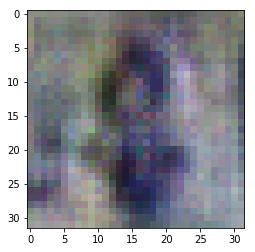

 97%|█████████▋| 999/1031 [01:05<00:02, 15.62it/s]

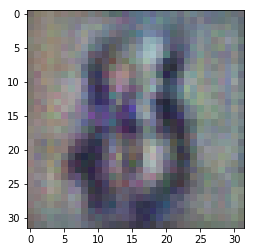

  0%|          | 0/1031 [00:00<?, ?it/s]


 Epoch  7  done.
Discriminator sum WD-GP Loss:  -1.787207841873169
Generator train Loss:  tensor(184549.7344, device='cuda:0', grad_fn=<AddBackward0>)
Batch time:  67.96057558059692 
 



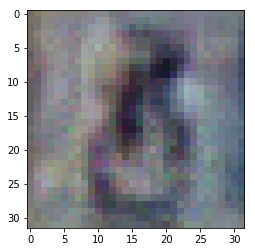

 97%|█████████▋| 999/1031 [01:05<00:02, 15.38it/s]

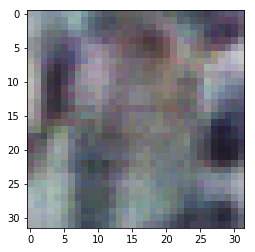

  0%|          | 0/1031 [00:00<?, ?it/s]


 Epoch  8  done.
Discriminator sum WD-GP Loss:  -1.8035908937454224
Generator train Loss:  tensor(173925.2188, device='cuda:0', grad_fn=<AddBackward0>)
Batch time:  67.9605073928833 
 



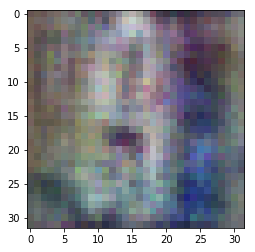

 97%|█████████▋| 999/1031 [01:05<00:02, 15.27it/s]

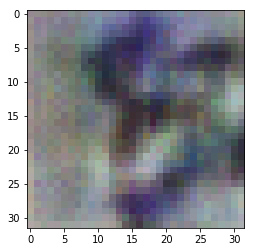

  0%|          | 0/1031 [00:00<?, ?it/s]


 Epoch  9  done.
Discriminator sum WD-GP Loss:  -1.7724475860595703
Generator train Loss:  tensor(165032.1250, device='cuda:0', grad_fn=<AddBackward0>)
Batch time:  68.21537232398987 
 



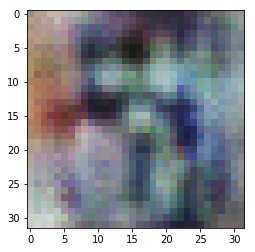

 97%|█████████▋| 999/1031 [01:05<00:02, 15.15it/s]

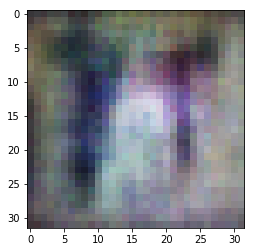

  0%|          | 0/1031 [00:00<?, ?it/s]


 Epoch  10  done.
Discriminator sum WD-GP Loss:  -1.7503688335418701
Generator train Loss:  tensor(157688.8125, device='cuda:0', grad_fn=<AddBackward0>)
Batch time:  68.38508152961731 
 



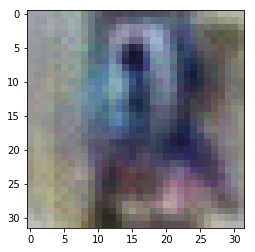

 97%|█████████▋| 999/1031 [01:05<00:02, 15.47it/s]

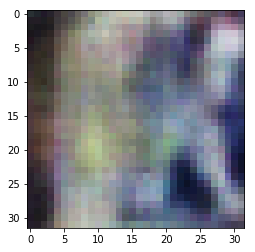

  0%|          | 0/1031 [00:00<?, ?it/s]


 Epoch  11  done.
Discriminator sum WD-GP Loss:  -1.7564246654510498
Generator train Loss:  tensor(150979.4844, device='cuda:0', grad_fn=<AddBackward0>)
Batch time:  68.02735376358032 
 



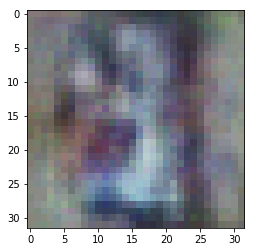

 97%|█████████▋| 999/1031 [01:05<00:02, 15.41it/s]

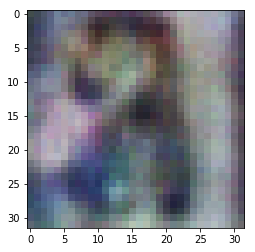

  0%|          | 0/1031 [00:00<?, ?it/s]


 Epoch  12  done.
Discriminator sum WD-GP Loss:  -1.8000885248184204
Generator train Loss:  tensor(145353.2031, device='cuda:0', grad_fn=<AddBackward0>)
Batch time:  68.08860898017883 
 



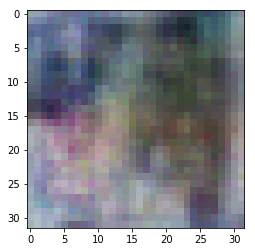

 97%|█████████▋| 999/1031 [01:05<00:02, 14.87it/s]

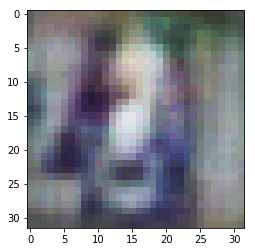

  0%|          | 0/1031 [00:00<?, ?it/s]


 Epoch  13  done.
Discriminator sum WD-GP Loss:  -1.7438671588897705
Generator train Loss:  tensor(140878.8594, device='cuda:0', grad_fn=<AddBackward0>)
Batch time:  68.29431772232056 
 



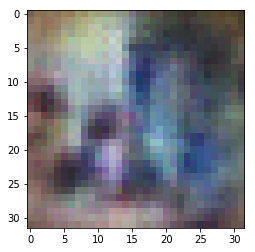

 97%|█████████▋| 999/1031 [01:05<00:02, 15.42it/s]

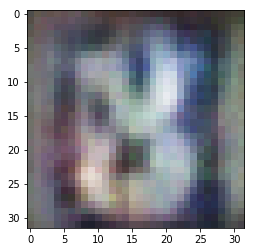

100%|██████████| 1031/1031 [01:08<00:00, 15.11it/s]


 Epoch  14  done.
Discriminator sum WD-GP Loss:  -1.7820969820022583
Generator train Loss:  tensor(137568.5156, device='cuda:0', grad_fn=<AddBackward0>)
Batch time:  68.32134771347046 
 

Total train time:  1019.9588422775269


In [10]:
import time as time
import shutil

try:
    shutil.rmtree('./samples/')
    os.mkdir('./samples/')
except:
    os.mkdir('./samples/')

    
generator_dc = Generator_dc().to(device)
discriminator_dc = Discriminator_dc().to(device)

optimizerD = optim.Adam(discriminator_dc.parameters(), lr=0.0002, betas=(0, 0.999)) 
optimizerG = optim.Adam(generator_dc.parameters(), lr=0.0002, betas=(0, 0.999)) 


img_list = []
ce_losses = []
G_losses = []
wdlosses = []
iters = 0
num_epochs = 15



start = time.time()
for epoch in range(num_epochs):
    b_start = time.time()
    g_sum = 0
    wdloss_sum = 0
    ce_loss_sum = 0
    for n_batch, (real_batch,_) in enumerate(tqdm(train_loader)):
        N = real_batch.shape[0]
        
          ##########################
          
        # 1. Train Discriminator
        
        #########################
          
        for i in range(2):
        #  Generate fake data 
            fake_data = generator_dc(get_noise(len(real_batch)))
            real_data = real_batch.to(device)
            # 
            wdloss = train_discriminator(N, optimizerD, real_data, fake_data)

        wdloss_sum = wdloss_sum + wdloss

         ######################
  
        # 2. Train Generator
    
        ####################
      
        # Generate fake data
             
        fake_data = generator_dc(get_noise(len(real_batch))).detach()
        
        # Train G
        g_error = train_generator(optimizerG, optimizerD, fake_data)
        # Summing the mse loss for epoch
        g_sum = g_sum + g_error
        
        
        
        if (n_batch) % 1000 == 0: 
            #print('Sample from Generator:')
            newImg1 = sample_gen(generator_dc)
            
            torch.save(newImg1, './samples/'+str(epoch) +'-'+str(n_batch)+".npy")
            
    wd = (wdloss_sum/n_batch).item() 
    wdlosses.append(wd)
    G_losses.append(g_sum)
    
    b_end = time.time()
    print('\n Epoch ', epoch, ' done.')
    print('Discriminator sum WD-GP Loss: ', wd)
    print('Generator train Loss: ', g_sum)
    print('Batch time: ', b_end - b_start, '\n \n')
    
    
end = time.time()
print('Total train time: ', end-start)

## Qualitative Eval

### 1. Provide visual samples.

In [0]:


def generate(model, n_samples=25, nrow=5, eps=0):
    plt.figure(figsize=(12,12))
    x = torch.randn(n_samples, 100).to(device)
    e = torch.Tensor(n_samples, 100).to(device)
    e.fill_(eps)
    
    z = x + e
    samples = model(z)
    
    samples = samples.detach().cpu()
    print(samples.shape)
    grid = torchvision.utils.make_grid(samples, nrow=nrow, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    

torch.Size([25, 3, 32, 32])


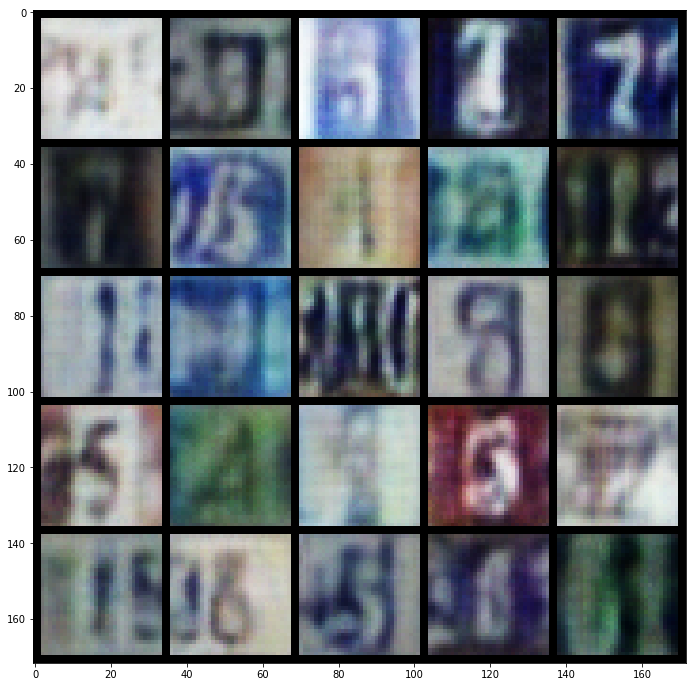

In [30]:
generate(generator_dc)

### 2. Disantagled Representation

In [0]:
def generate_with_perturbation(model, dim=100, nrow=10, eps=0):
    plt.figure(figsize=(8,8))
    
    # sample from prior and repeat that tensor the number of dimensions
    z = torch.randn(dim)
    z = z.repeat(dim, 1).to(device)
    
    # apply perturbation using epsilon 
    for i in range(dim):
      z[i][i] += eps
      
    samples = model(z)
    samples = samples.detach().cpu()
    grid = torchvision.utils.make_grid(samples, nrow=nrow, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))

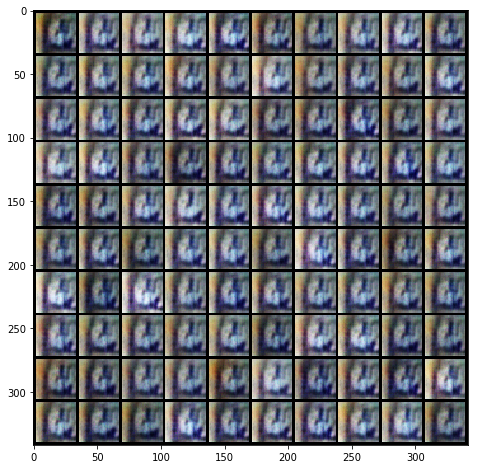

In [14]:
generate_with_perturbation(generator_dc, eps=-1.5)

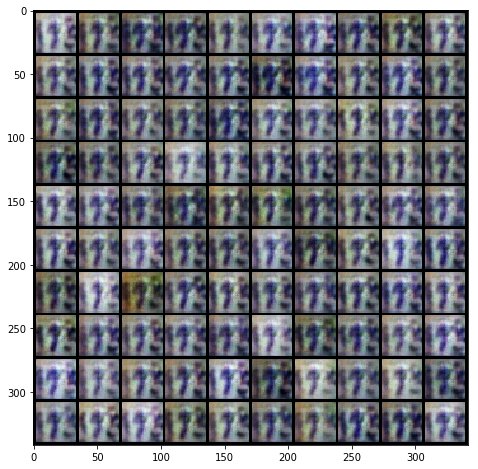

In [15]:
generate_with_perturbation(generator_dc, eps=1.5)

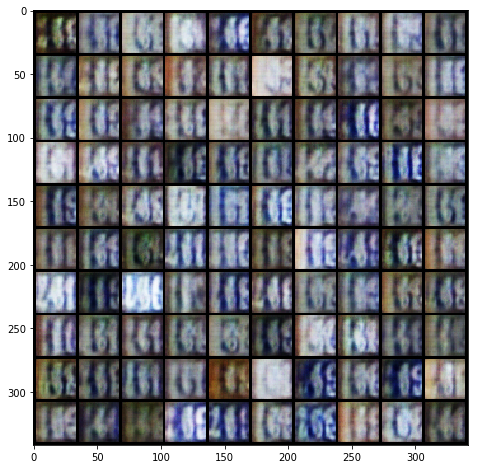

In [16]:
generate_with_perturbation(generator_dc, eps=-5)

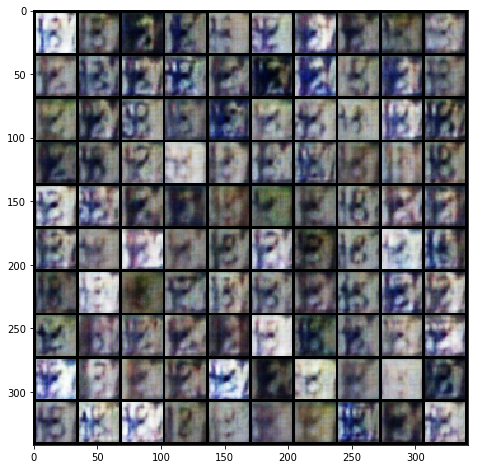

In [17]:
generate_with_perturbation(generator_dc, eps=5)

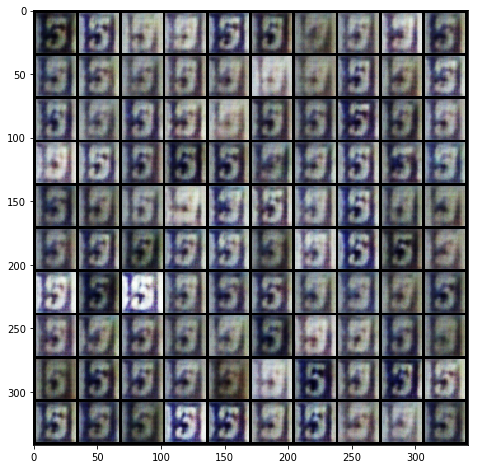

In [18]:
generate_with_perturbation(generator_dc, eps=-3)

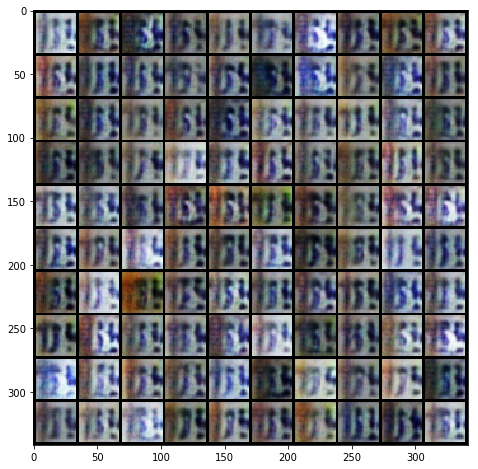

In [19]:
generate_with_perturbation(generator_dc, eps=3)

### 3. Compare between interpolating in the data space and in the latent space.


In [0]:
def interpolation(model):
  model.eval()
  alpha = np.around(np.arange(0.0, 1.0, 0.1), 1)
  
  # Latent space interpolation
  z0 = torch.randn(1, 100).to(device)
  z1 = torch.randn(1, 100).to(device)
  samples = torch.zeros((10,3,32,32))
  for idx, a in enumerate(alpha):
    z = a * z0 + (1 - a) * z1
    samples[idx] = model(z).detach().cpu()
   
  latent_grid = torchvision.utils.make_grid(samples, nrow=10, normalize=True)

  # Data space interpolation
  x0 = model(z0)
  x0 = x0.detach().cpu()
  x1 = model(z1)
  x1 = x1.detach().cpu()
  samples = torch.zeros((10,3,32,32))
  for idx, a in enumerate(alpha):
    samples[idx] = a * x0 + (1 - a) * x1

  data_grid = torchvision.utils.make_grid(samples, nrow=10, normalize=True)

  return latent_grid, data_grid

In [0]:
latent_grid, data_grid = interpolation(generator_dc)
latent_grid1, data_grid1 = interpolation(generator_dc)
latent_grid2, data_grid2 = interpolation(generator_dc)
latent_grid3, data_grid3 = interpolation(generator_dc)

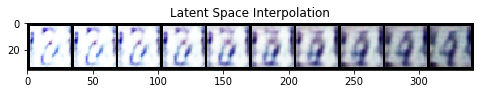

In [46]:
plt.figure(figsize=(8,8))
plt.title('Latent Space Interpolation')
plt.imshow(latent_grid.permute(1, 2, 0))

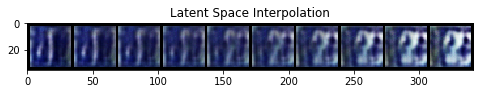

In [47]:
plt.figure(figsize=(8,8))
plt.title('Latent Space Interpolation')
plt.imshow(latent_grid1.permute(1, 2, 0))

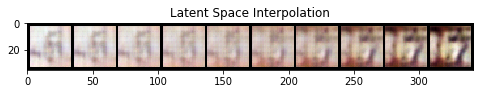

In [48]:
plt.figure(figsize=(8,8))
plt.title('Latent Space Interpolation')
plt.imshow(latent_grid2.permute(1, 2, 0))

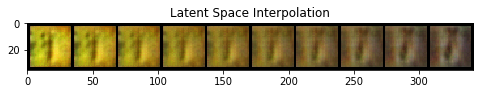

In [49]:
plt.figure(figsize=(8,8))
plt.title('Latent Space Interpolation')
plt.imshow(latent_grid3.permute(1, 2, 0))

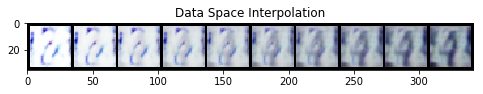

In [45]:
plt.figure(figsize=(8,8))
plt.title('Data Space Interpolation')
plt.imshow(data_grid.permute(1, 2, 0))

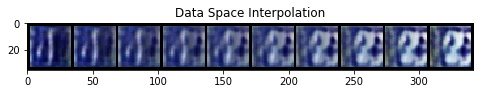

In [44]:
plt.figure(figsize=(8,8))
plt.title('Data Space Interpolation')
plt.imshow(data_grid1.permute(1, 2, 0))

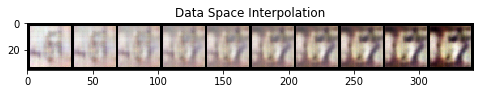

In [43]:
plt.figure(figsize=(8,8))
plt.title('Data Space Interpolation')
plt.imshow(data_grid2.permute(1, 2, 0))

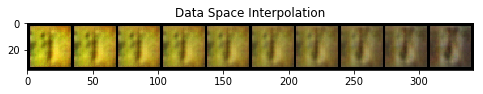

In [42]:
plt.figure(figsize=(8,8))
plt.title('Data Space Interpolation')
plt.imshow(data_grid3.permute(1, 2, 0))

## Quantitative eval

In [0]:
os.mkdir('./drive/My Drive/13_dl_assignment3/data/sample_directory/samples/')


In [0]:
def save_samples(model, path):
  for i in range(1000):
      z = torch.randn(1,100).to(device)
      samples = model(z)
      samples = samples.cpu()
  
      save_image(samples, path + "sample{}.png".format(i), normalize=True)

    
gan_path = "./drive/My Drive/13_dl_assignment3/data/sample_directory/samples/"
save_samples(generator_dc, gan_path)

#### Get FID score using our Github repo 

In [34]:
!rm -rf './IFT6135H19_A3' 
    
!git clone https://github.com/yaswagner/IFT6135H19_A3.git

!python3 ./IFT6135H19_A3/assignment3/Q3/score_fid.py './drive/My Drive/13_dl_assignment3/data/' --model='./IFT6135H19_A3/assignment3/Q3/svhn_classifier.pt'

Cloning into 'IFT6135H19_A3'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 480 (delta 6), reused 10 (delta 1), pack-reused 455
Receiving objects: 100% (480/480), 14.93 MiB | 26.09 MiB/s, done.
Resolving deltas: 100% (214/214), done.
Using downloaded and verified file: svhn/test_32x32.mat
FID score: 12001.04754853839
